# Group selfie

In [2]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
import selfies as sf
import group_selfies as gsf
from rdkit import Chem

random.seed(42)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Draw fragmentation

In [3]:
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
import rdkit.Chem.Draw as Draw
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from rdkit import RDLogger

RDLogger.DisableLog("rdApp.*")

##from https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/thread/CAHGTkV8sdfb4Q7FLn9C5MTwrqiJjHtnXK%2Bmz2SY3_4j2eAtevQ%40mail.gmail.com/#msg36477772
from rdkit.Chem.Draw import rdMolDraw2D

try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO


def DrawMolsZoomed(
    mols, legends, molsPerRow=3, subImgSize=(300, 300)
):  # , leg): #https://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html#rdkit.Chem.Draw.rdMolDraw2D.MolDraw2D
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow:
        nRows += 1
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    full_image = Image.new("RGBA", fullSize)
    for ii, mol in enumerate(mols):
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        le = legends[ii]
        column = ii % molsPerRow
        row = ii // molsPerRow
        offset = (column * subImgSize[0], row * subImgSize[1])
        d2d = rdMolDraw2D.MolDraw2DCairo(subImgSize[0], subImgSize[1])
        d2d.DrawMolecule(mol, legend=le)
        d2d.FinishDrawing()
        sub = Image.open(BytesIO(d2d.GetDrawingText()))
        full_image.paste(sub, box=offset)
    return full_image


# Input data

## Extract data from PsychLight file

In [6]:
# import data from PsychLight
PsychLight_data = pd.read_csv(
    "https://raw.githubusercontent.com/HauserGroup/PsyModTraining/refs/heads/main/data/PsychLight/PsychLight_TrainingSet.csv"
)
print(PsychLight_data.tail())

file_autofragmentation = pd.read_csv(
    "https://raw.githubusercontent.com/XiaotingLiu620/Project1/refs/heads/main/PCA/psychedelics_all_fingerprints.csv?token=GHSAT0AAAAAAC3PXPRLPTEAWMS7B7YHXJ3GZ3FEZ4A"
)
print(file_autofragmentation.head())
print(len(file_autofragmentation))

    Class  Known              ID  \
49      0  known      ketanserin   
50      0  known      MDL 100907   
51      0  known          prozac   
52      0  known  tabernanthalog   
53      0  known        5-Br-DMT   

                                               SMILES  
49  O=C(c1ccc(F)cc1)C1CCN(CCn2c(=O)[nH]c3ccccc3c2=...  
50      COc1cccc([C@H](O)C2CCN(CCc3ccc(F)cc3)CC2)c1OC  
51                 CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1  
52                     COc1ccc2c3c([nH]c2c1)CCN(C)CC3  
53                        CN(C)CCc1c[nH]c2ccc(Br)cc12  
                     Name    Category     CID  \
0               Quipazine  Piperazine    5011   
1                   MK212  Piperazine  107992   
2  N,N-Dimethyltryptamine  Tryptamine    6089   
3                Psilocin  Tryptamine    4980   
4              Psilocybin  Tryptamine   10624   

                                            Synonyms  \
0  ['quipazine', '2-Piperazin-1-yl-quinoline', '4...   
1  ['MK-212', '64022-27-1', '2-Chloro-6-

## Generate group selfie encoding

### Generate group grammar with all psychedelic fingerprints

In [7]:
# data preparation for fragmenting using X_train
SMILES_autofragmentation = file_autofragmentation["Canonical SMILES"].tolist()

print(SMILES_autofragmentation)

['C1CN(CCN1)C2=NC3=CC=CC=C3C=C2', 'C1CN(CCN1)C2=CN=CC(=N2)Cl', 'CN(C)CCC1=CNC2=CC=CC=C21', 'CN(C)CCC1=CNC2=C1C(=CC=C2)O', 'CN(C)CCC1=CNC2=C1C(=CC=C2)OP(=O)(O)O', 'COC1=CC=CC=C1CNCCC2=CC(=C(C=C2OC)Br)OC', 'CC(C)CC1C(=O)N2CCCC2C3(N1C(=O)C(O3)(C(C)C)NC(=O)C4CN(C5CC6=C(NC7=CC=CC(=C67)C5=C4)Br)C)O', 'CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)NC(=O)C5CN(C6CC7=CNC8=CC=CC(=C78)C6=C5)C', 'CCN(CC)C(=O)NC1CN(C2CC3=CNC4=CC=CC(=C34)C2=C1)C', 'C1=CC2=C(C=C1O)C(=CN2)CC(C(=O)O)N', 'CN(C)CCC1=CNC2=C1C=C(C=C2)OC', 'C1=CC(=C(C=C1CCN)O)O', 'CN1CCC2=C3C1CC4=C(C3=CC=C2)C(=C(C=C4)O)O', 'CNCC(C1=CC(=C(C=C1)O)O)O', 'CC(CC1=CC2=C(C=C1)OCO2)NC', 'CC(CC1=CC2=C(C=C1)OCO2)N', 'COC1=CC(=C(C=C1CCNCC2=CC=CC=C2O)OC)Cl', 'CCN(CC)C(=O)C1CN(C2CC3=CNC4=CC=CC(=C34)C2=C1)C', 'CCCN1CCCC2C1CC3=C(C2)NN=C3', 'CC1=CC(=C(C=C1OC)C2CC2N)OC', 'CCOC1=C(C=C(C=C1OC)CCN)OC', 'CC(=C)COC1=C(C=C(C=C1OC)CCN)OC', 'CCC(CC1=C(C=C(C(=C1)OC)C)OC)N.Cl', 'CC(CC1=CC(=C(C=C1OC)SC)OC)N', 'CC(CC1=CC2=C(C=C1)OCC2)NC', 'CCN(CC)C1=CC2=C(C=C1)C(=C(C(=O

#### default

In [8]:
# generate grammar and dictionary of fragments

# get smiles list from PsychLight data
molecules = [Chem.MolFromSmiles(smiles) for smiles in SMILES_autofragmentation]

# extracting a set of reasonable groups using fragmentation
fragments = gsf.fragment_mols(molecules, method="default")

# create a dictionary of fragments for tracking
vocab_fragment = dict(
    [
        (f"frag{idx}", gsf.Group(f"frag{idx}", frag))
        for idx, frag in enumerate(fragments)
    ]
)

print(fragments)

100%|██████████| 252/252 [00:04<00:00, 53.56it/s]


['C(C(N(C*1)*1)*1)*1', 'C1=CC2=C3C(=C1)N(*1)C(*1)=C3CC1C2=CC(*1)CN1*1', 'C1=CC2=C3C(=CNC3=C1)CC1C2=CC(*1)CN1*1', 'C1=CC=C2C(=C1)NC(*1)=C2*1', 'C1=CC(*1)=C(*1)C=C1*1', 'CC(N)C*1', 'C1=C(*1)C2=C(C=C(*1)C(*1)=C2*1)N1*1', 'C(=C(C(=C(*1)*1)*1)*1)(C(=C(*1)*1)*1)*1', 'C1=C(*1)C=C(*1)C2=C1OC(*1)(*1)O2']


In [9]:
print(len(fragments))


9


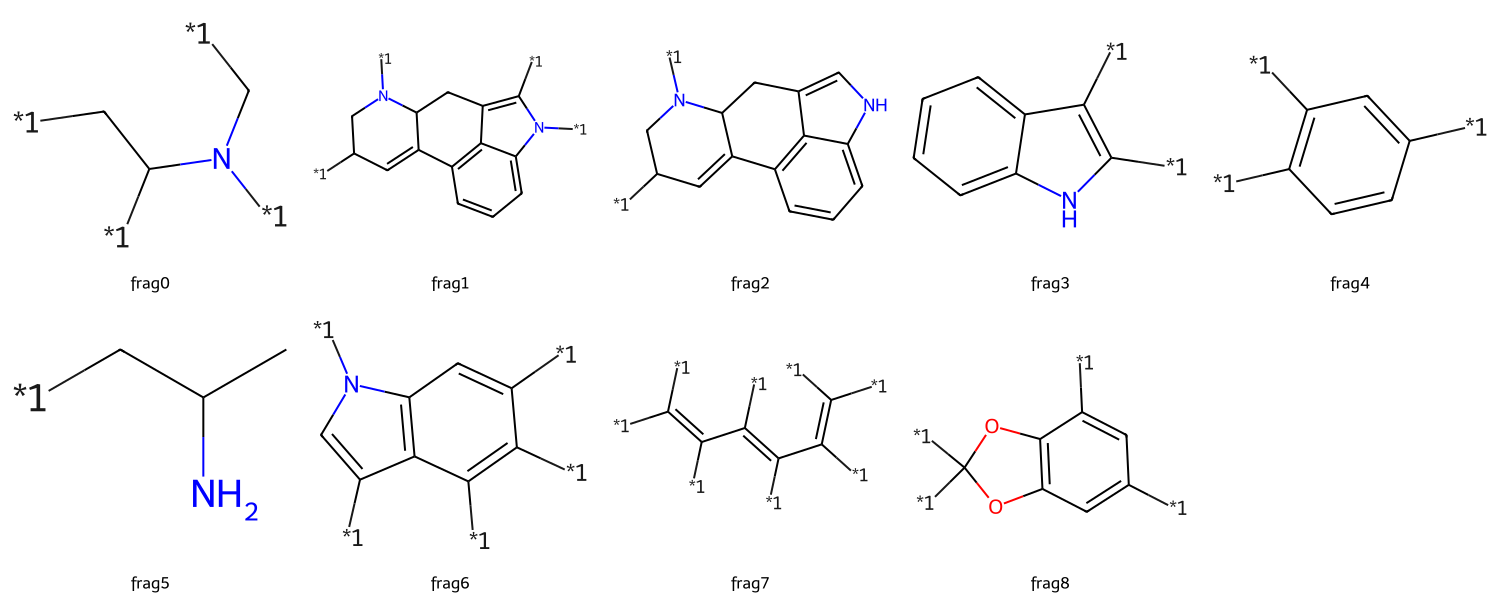

In [10]:
# Ensure the number of legends matches the number of molecules
draw_fragment_default = [g.mol for g in vocab_fragment.values()]
legends_default = [f"frag{idx}" for idx in range(len(molecules))]

display(
    DrawMolsZoomed(
        draw_fragment_default,
        legends=legends_default,molsPerRow=5
    )
)


#### mmpa

In [11]:
# extracting a set of reasonable groups using fragmentation
fragments_mmpa = gsf.fragment_mols(molecules, method="mmpa")

# create a dictionary of fragments for tracking
vocab_fragment_mmpa = dict(
    [(f"frag{idx}", gsf.Group(f"frag{idx}", frag)) for idx, frag in enumerate(fragments_mmpa)]
) 

print(fragments_mmpa)
print(len(fragments_mmpa))

100%|██████████| 252/252 [01:38<00:00,  2.56it/s]


['C(C(*1)*1)(N(C(*1)*1)*1)*1', 'C1=CC2=C3C(=C1)C1=CC(*1)CN(*1)C1CC3=C(*1)N2*1', 'C1=CC2=C3C(=CN2)CC2C(=CC(*1)CN2*1)C3=C1', 'O=C(C1C=C2C3=CC=CC4=C3C(=CN4*1)CC2N(*1)C1)N(CC*1)*1', 'O=C(C1C=C2C3=CC=CC4=C3C(=CN4)CC2N(*1)C1)N(C(C*1)*1)*1', 'COC1=CC(SC(*1)*1)=C(OC)C=C1*1', 'C1=C(CC(N*1)*1)C(O*1)=C(*1)C(*1)=C1O*1', 'COC1=CC(*1)=C(*1)C=C1CCNCC1=CC=CC=C1*1', 'C(C(C*1)N(*1)*1)*1', 'COC1=C(SC(*1)*1)C=C(*1)C(CC(*1)*1)=C1', 'COC1=CC(SC(C*1)*1)=C(O*1)C=C1C*1', 'COC1=C(S*1)C=C(O*1)C(C*1)=C1', 'C(OC1=C(OC(*1)*1)C(*1)=C(*1)C(C(C(*1)*1)*1)=C1*1)*1', 'O=C(N(C(*1)*1)*1)*1', 'CC(CC1=CC(O*1)=C(*1)C(*1)=C1*1)N*1', 'C1=CC(*1)=C(*1)C2=C1NC(*1)=C2CCN(C(C*1)*1)C(*1)*1', 'C(C*1)N(C(C*1)*1)C(C*1)*1', 'C1=C(CC(*1)*1)C=C(OC*1)C(OC(*1)*1)=C1OC*1', 'COC1=CC(SC(*1)*1)=C(OC)C=C1CC(*1)*1', 'COC1=C(*1)C(*1)=C(OC)C(CCNCC2=CC=CC=C2*1)=C1', 'C(OC1=C(*1)C(OC*1)=C(*1)C(*1)=C1*1)*1', 'COC1=CC=CC=C1CNCCC1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'CC(CC1=CC(*1)=C(*1)C(*1)=C1O*1)N*1', 'C(C*1)C(N(*1)*1)*1', 'C1(C(C(*1)*1)*1)=C(*1)C(*1)=C(*1)C(

{'frag0': <Group frag0 C(C(*1)*1)(N(C(*1)*1)*1)*1>, 'frag1': <Group frag1 C1=CC2=C3C(=C1)C1=CC(*1)CN(*1)C1CC3=C(*1)N2*1>, 'frag2': <Group frag2 C1=CC2=C3C(=CN2)CC2C(=CC(*1)CN2*1)C3=C1>, 'frag3': <Group frag3 O=C(C1C=C2C3=CC=CC4=C3C(=CN4*1)CC2N(*1)C1)N(CC*1)*1>, 'frag4': <Group frag4 O=C(C1C=C2C3=CC=CC4=C3C(=CN4)CC2N(*1)C1)N(C(C*1)*1)*1>, 'frag5': <Group frag5 COC1=CC(SC(*1)*1)=C(OC)C=C1*1>, 'frag6': <Group frag6 C1=C(CC(N*1)*1)C(O*1)=C(*1)C(*1)=C1O*1>, 'frag7': <Group frag7 COC1=CC(*1)=C(*1)C=C1CCNCC1=CC=CC=C1*1>, 'frag8': <Group frag8 C(C(C*1)N(*1)*1)*1>, 'frag9': <Group frag9 COC1=C(SC(*1)*1)C=C(*1)C(CC(*1)*1)=C1>, 'frag10': <Group frag10 COC1=CC(SC(C*1)*1)=C(O*1)C=C1C*1>, 'frag11': <Group frag11 COC1=C(S*1)C=C(O*1)C(C*1)=C1>, 'frag12': <Group frag12 C(OC1=C(OC(*1)*1)C(*1)=C(*1)C(C(C(*1)*1)*1)=C1*1)*1>, 'frag13': <Group frag13 O=C(N(C(*1)*1)*1)*1>, 'frag14': <Group frag14 CC(CC1=CC(O*1)=C(*1)C(*1)=C1*1)N*1>, 'frag15': <Group frag15 C1=CC(*1)=C(*1)C2=C1NC(*1)=C2CCN(C(C*1)*1)C(*1)*1>, 

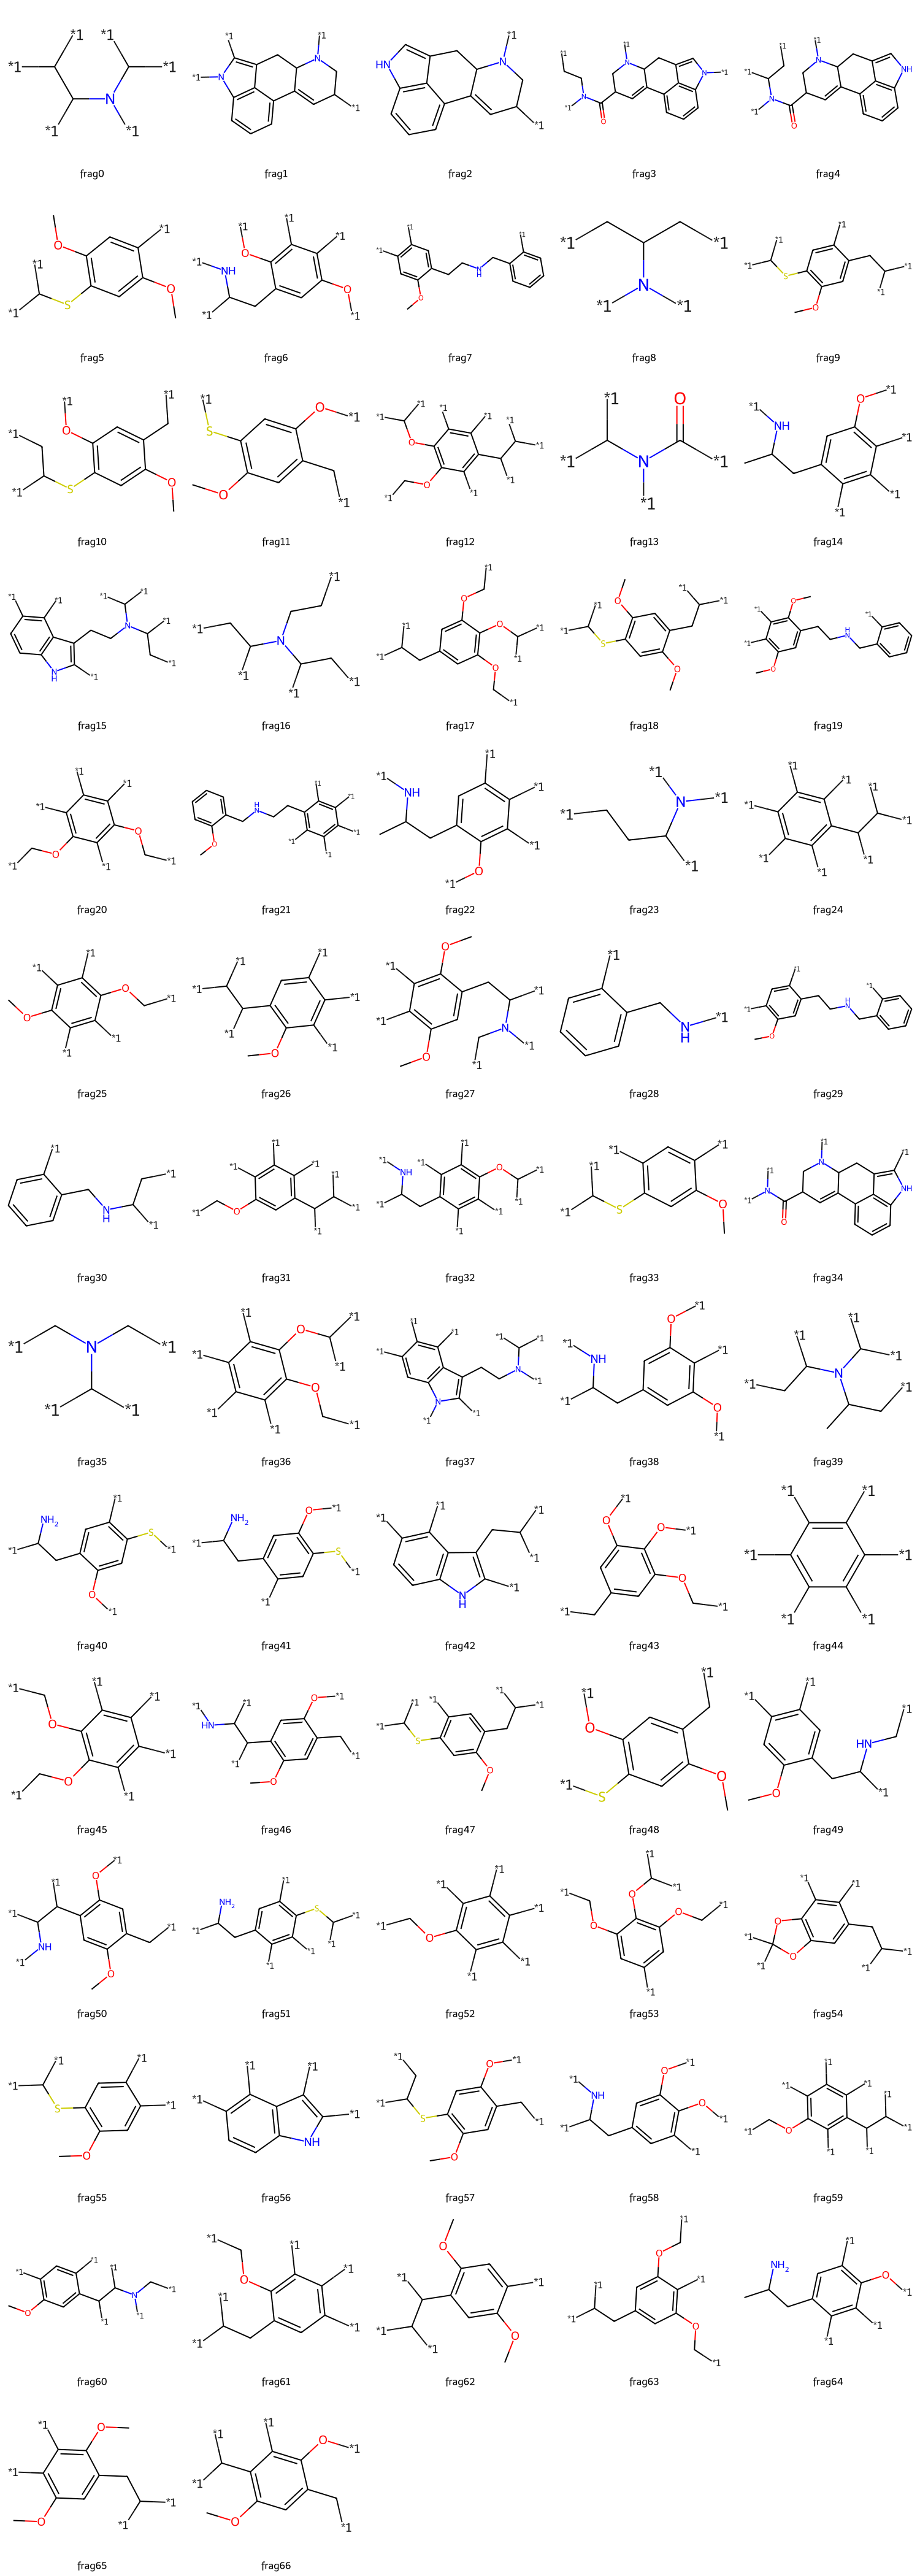

In [12]:
print(vocab_fragment_mmpa)
draw_fragment_mmpa = [f.mol for f in vocab_fragment_mmpa.values()]
print(len(draw_fragment_mmpa)) 
legends_mmpa = [f"frag{idx}" for idx in range(len(draw_fragment_mmpa))]

display(
    DrawMolsZoomed(
        draw_fragment_mmpa,
        legends=legends_mmpa,molsPerRow=5
    )
)


#### fraggle

In [13]:
# extracting a set of reasonable groups using fragmentation
fragments_fraggle = gsf.fragment_mols(molecules, method="fraggle")

# create a dictionary of fragments for tracking
vocab_fragments_fraggle = dict(
    [
        (f"frag{idx}", gsf.Group(f"frag{idx}", frag))
        for idx, frag in enumerate(fragments_fraggle)
    ]
)

print(fragments_fraggle)
print(len(fragments_fraggle))


100%|██████████| 252/252 [00:23<00:00, 10.59it/s]


['CN(C*1)C(*1)*1', 'C1OC(*1)=C(*1)O1', 'C1=C2OCOC2=C(*1)C(*1)=C1', 'C1=CC(*1)=C2C(=C1)NC=C2*1', 'C1(*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'CC(N)C*1', 'COC1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'C1=CC2=C(C(*1)=C1)C(*1)=CN2', 'C(C(N(C*1)*1)*1)*1', 'CN1CC(*1)C=C2C3=CC=CC4=C3C(=CN4)CC21', 'C1=CC=C2C(CC*1)=CNC2=C1', 'COC1=CC=C2NC(*1)=C(*1)C2=C1', 'CN(C)CCC1=CNC(*1)=C1*1', 'COC1=CC(CCN)=C(OC)C=C1*1', 'COC1=CC(CCN)=CC(OC)=C1*1', 'CC(N)CC1=CC(*1)=C(*1)C(*1)=C1', 'CN1CC(C(=O)*1)C=C2C3=CC=CC4=C3C(=CN4)CC21', 'CCC(C*1)*1', 'COC1=CC=CC=C1CN*1']
19


{'frag0': <Group frag0 C(N(C*1)C(*1)*1)*1>, 'frag1': <Group frag1 COC1=CC=C2C(=C1)C(*1)=C(*1)N2*1>, 'frag2': <Group frag2 COC1=CC=C2NC(*1)=C(*1)C2=C1>, 'frag3': <Group frag3 CN(C)CCC1=CNC(*1)=C1*1>, 'frag4': <Group frag4 C1=CC=C2C(CC*1)=CNC2=C1>, 'frag5': <Group frag5 CCC(C*1)*1>, 'frag6': <Group frag6 CC(N)C*1>, 'frag7': <Group frag7 C1OC(*1)=C(*1)O1>, 'frag8': <Group frag8 COC1=CC(CCN)=C(OC)C=C1*1>, 'frag9': <Group frag9 C(C(N(C*1)*1)*1)*1>, 'frag10': <Group frag10 COC1=CC=CC=C1CN*1>, 'frag11': <Group frag11 C1(*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1>, 'frag12': <Group frag12 COC1=CC(CCN)=CC(OC)=C1*1>, 'frag13': <Group frag13 C1=CC2=C(C(*1)=C1)C(*1)=CN2>, 'frag14': <Group frag14 O=C(C*1)O*1>, 'frag15': <Group frag15 CC(N)CC1=CC(*1)=C(*1)C(*1)=C1>, 'frag16': <Group frag16 CN1CC(C(=O)*1)C=C2C3=CC=CC4=C3C(=CN4)CC21>, 'frag17': <Group frag17 C1=C2NC(*1)=C(*1)C2=C(*1)C(*1)=C1>, 'frag18': <Group frag18 COC1=C(*1)C(*1)=C(*1)C(*1)=C1*1>, 'frag19': <Group frag19 CN1CC(*1)C=C2C3=CC=CC4=C3C(=CN4)CC21>, 

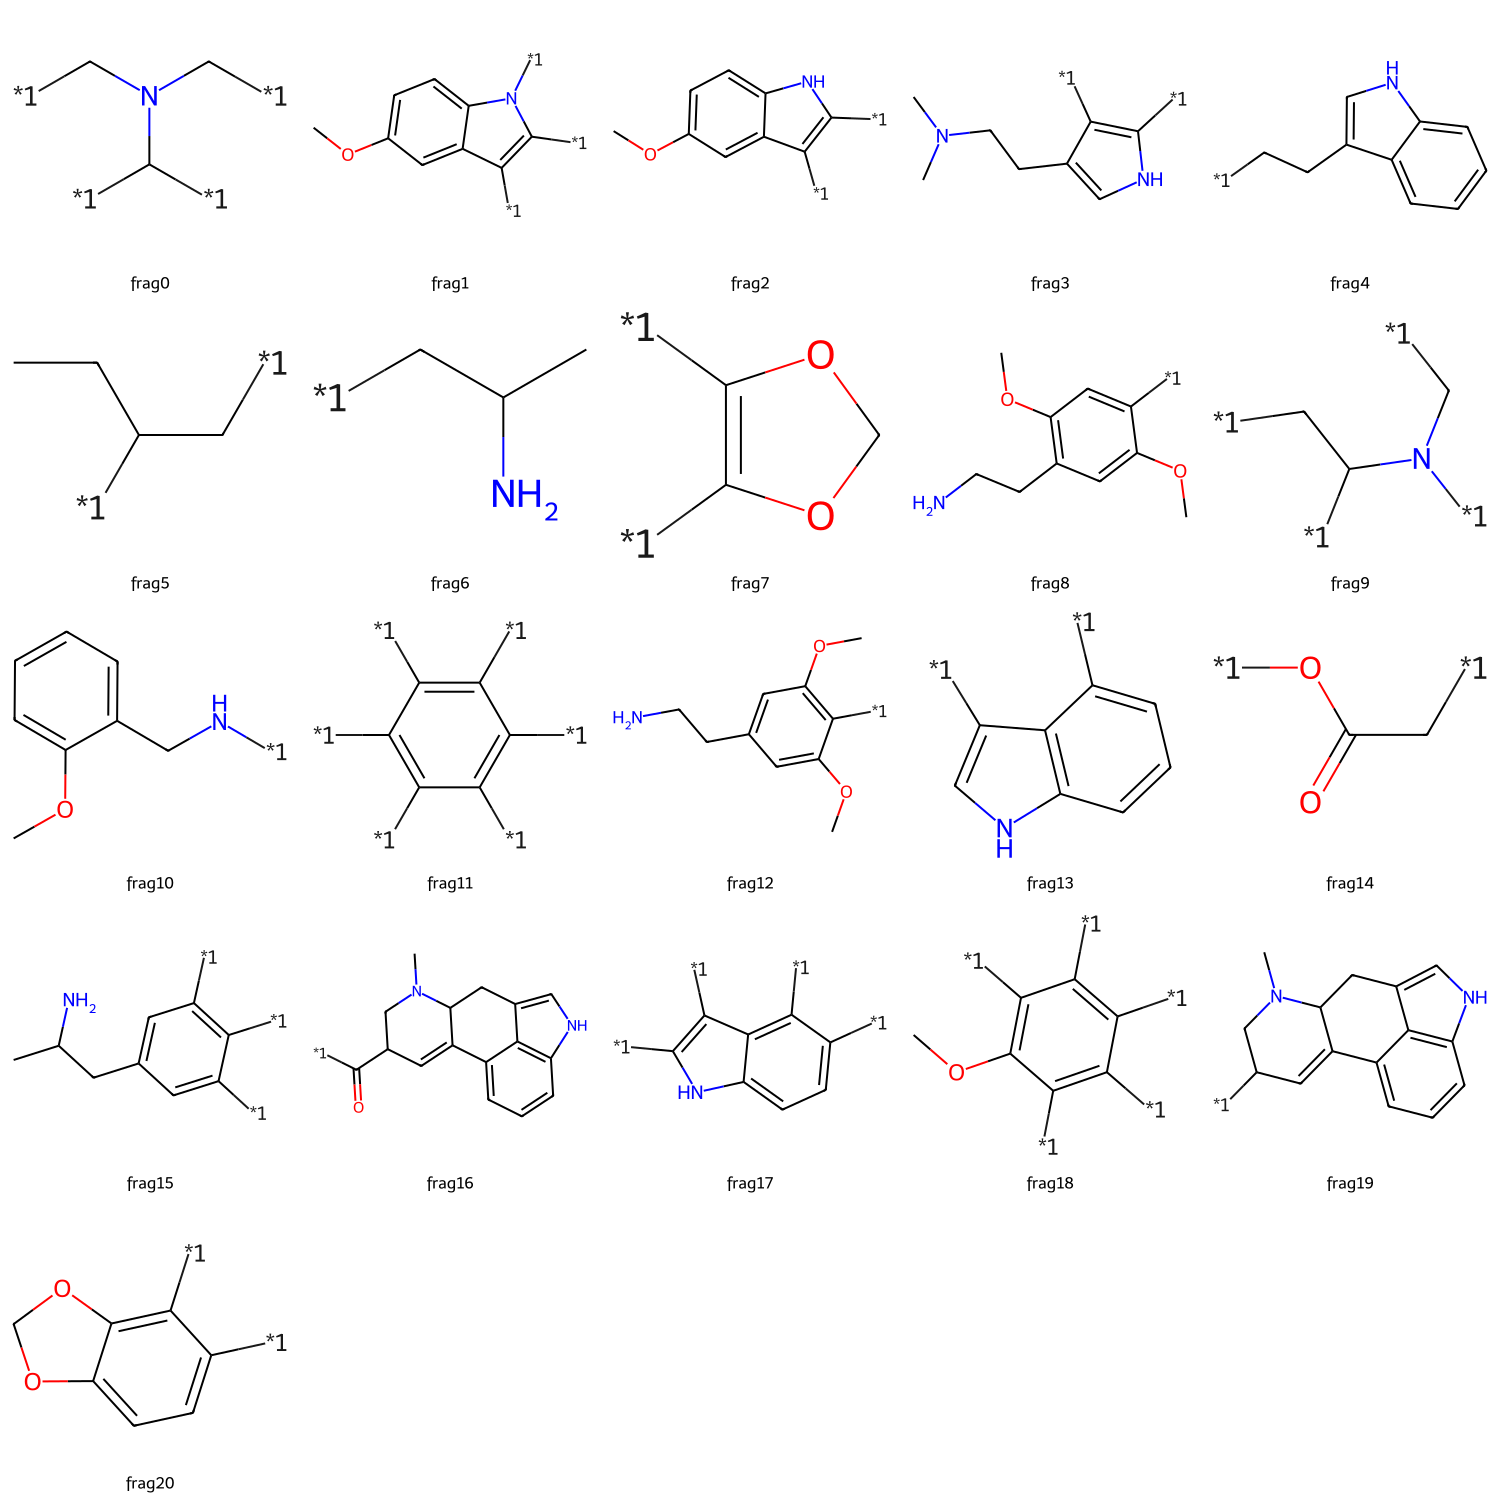

In [143]:
print(vocab_fragments_fraggle)
draw_fragment_fraggle = [f.mol for f in vocab_fragments_fraggle.values()]
print(len(draw_fragment_fraggle))
legends_fraggle = [f"frag{idx}" for idx in range(len(draw_fragment_fraggle))]

display(DrawMolsZoomed(draw_fragment_fraggle, legends=legends_fraggle, molsPerRow=5))


In [14]:
# create a GroupGrammar object using the predefined fragment vocabulary
grammar_auto_default = gsf.GroupGrammar(vocab=vocab_fragment)
grammar_auto_mmpa = gsf.GroupGrammar(vocab=vocab_fragment_mmpa)
grammar_auto_fraggle = gsf.GroupGrammar(vocab=vocab_fragments_fraggle)


# Group selfie encoding for psychedelic drug only

In [15]:
# separate the dataset into psy and nonpsy
psy_PsychLight_data = PsychLight_data[PsychLight_data["Class"] == 1]
nonpsy_PsychLight_data = PsychLight_data[PsychLight_data["Class"] == 0]

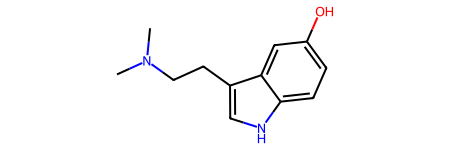

In [19]:
# encode for only the psy data
encode_input = [Chem.MolFromSmiles(smiles) for smiles in psy_PsychLight_data["SMILES"]]
display(encode_input[0])

## default

In [39]:
group_selfies_default = []
extracted_groups_default = []


for smiles in encode_input:
    encode_mol = grammar_auto_default.full_encoder(smiles)
    group_selfies_default.append(encode_mol)
    extracted = grammar_auto_default.extract_groups(smiles)
    extracted_group = [group.name for group,_,_ in extracted]
    extracted_groups_default.append(extracted_group)

print(extracted_groups_default)
# print(len(group_selfies))

[['frag7', 'frag0'], ['frag3', 'frag0'], ['frag0'], ['frag6', 'frag0'], ['frag7', 'frag0'], ['frag3'], ['frag7', 'frag0'], ['frag7', 'frag0'], ['frag7', 'frag0'], ['frag3', 'frag0'], [], ['frag5'], ['frag7', 'frag0'], ['frag7', 'frag0'], [], ['frag7', 'frag0'], ['frag7', 'frag0'], ['frag7', 'frag0']]


## mmpa

In [31]:
group_selfie_mmpa = []
extracted_groups_mmpa = []


for smiles in encode_input:
    encode_mol = grammar_auto_mmpa.full_encoder(smiles)
    group_selfie_mmpa.append(encode_mol)
    extracted = grammar_auto_mmpa.extract_groups(smiles)
    extracted_group = [group.name for group, _, _ in extracted]
    extracted_groups_mmpa.append(extracted_group)
    print(extracted_group)

print(extracted_groups_mmpa)

['frag44', 'frag0']
['frag44', 'frag0']
['frag62', 'frag28']
['frag56', 'frag0']
['frag44', 'frag0']
['frag44']
['frag44', 'frag0']
['frag44', 'frag0']
['frag52', 'frag0']
['frag44', 'frag0']
['frag44']
['frag62']
['frag44', 'frag0']
['frag52', 'frag0']
['frag62']
['frag44', 'frag0']
['frag44', 'frag0']
['frag44', 'frag0']
[['frag44', 'frag0'], ['frag44', 'frag0'], ['frag62', 'frag28'], ['frag56', 'frag0'], ['frag44', 'frag0'], ['frag44'], ['frag44', 'frag0'], ['frag44', 'frag0'], ['frag52', 'frag0'], ['frag44', 'frag0'], ['frag44'], ['frag62'], ['frag44', 'frag0'], ['frag52', 'frag0'], ['frag62'], ['frag44', 'frag0'], ['frag44', 'frag0'], ['frag44', 'frag0']]


## fraggle

In [32]:
group_selfies_fraggle = []
extracted_groups_fraggle = []


for smiles in encode_input:
    encode_mol = grammar_auto_fraggle.full_encoder(smiles)
    group_selfies_fraggle.append(encode_mol)
    extracted = grammar_auto_fraggle.extract_groups(smiles)
    extracted_group = [group.name for group, _, _ in extracted]
    extracted_groups_fraggle.append(extracted_group)
    print(extracted_group)

print(extracted_groups_fraggle)


['frag4', 'frag0']
['frag10']
['frag6', 'frag4', 'frag8']
['frag7', 'frag8']
['frag4', 'frag8']
['frag10']
['frag4', 'frag0']
['frag3', 'frag0']
['frag11', 'frag0']
['frag10']
['frag2']
['frag6', 'frag5']
['frag4', 'frag8']
['frag11', 'frag8']
['frag13']
['frag3', 'frag0']
['frag4', 'frag0']
['frag4', 'frag0']
[['frag4', 'frag0'], ['frag10'], ['frag6', 'frag4', 'frag8'], ['frag7', 'frag8'], ['frag4', 'frag8'], ['frag10'], ['frag4', 'frag0'], ['frag3', 'frag0'], ['frag11', 'frag0'], ['frag10'], ['frag2'], ['frag6', 'frag5'], ['frag4', 'frag8'], ['frag11', 'frag8'], ['frag13'], ['frag3', 'frag0'], ['frag4', 'frag0'], ['frag4', 'frag0']]


## One-hot encode group selfies

In [17]:
# find the unique groups
all_fragments = set(fragment for row in extracted_groups for fragment in row)

# create a DataFrame to store the One-Hot encoding
one_hot_df = pd.DataFrame(
    0, index=range(len(extracted_groups)), columns=sorted(all_fragments)
)

# fill in the DataFrame with the One-Hot encoding
for i, row in enumerate(extracted_groups):
    one_hot_df.loc[i, row] = 1

print(one_hot_df)


    frag0  frag3  frag5  frag6  frag7
0       1      0      0      0      1
1       1      1      0      0      0
2       1      0      0      0      0
3       1      0      0      1      0
4       1      0      0      0      1
5       0      1      0      0      0
6       1      0      0      0      1
7       1      0      0      0      1
8       1      0      0      0      1
9       1      1      0      0      0
10      0      0      0      0      0
11      0      0      1      0      0
12      1      0      0      0      1
13      1      0      0      0      1
14      0      0      0      0      0
15      1      0      0      0      1
16      1      0      0      0      1
17      1      0      0      0      1


## Upset Plot for psy

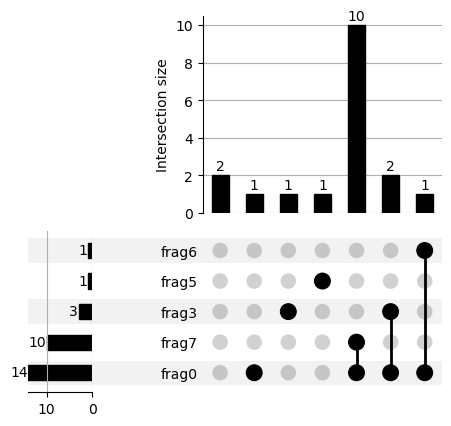

In [27]:
from upsetplot import UpSet
import matplotlib.pyplot as plt
import pandas as pd

# one-hot 
all_fragments_default = set(
    fragment for row in extracted_groups_default for fragment in row
)
one_hot_df_default = pd.DataFrame(
    0, index=range(len(extracted_groups_default)), columns=sorted(all_fragments_default)
)
for i, row in enumerate(extracted_groups_default):
    one_hot_df_default.loc[i, row] = 1

# convert One-Hot encoded data to 'MultiIndex Series'
# and count the number of occurrences of each group
upset_data_default = one_hot_df_default.value_counts()

# create an UpSet plot
upset_default = UpSet(upset_data_default, show_counts="%d")
upset_default.plot()

plt.show()


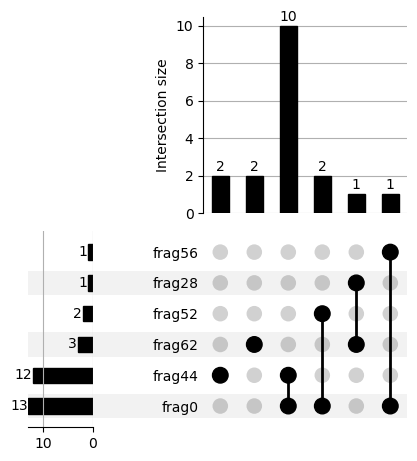

In [33]:
# one-hot
all_fragments_mmpa = set(fragment for row in extracted_groups_mmpa for fragment in row)
one_hot_df_mmpa = pd.DataFrame(
    0, index=range(len(extracted_groups_mmpa)), columns=sorted(all_fragments_mmpa)
)
for i, row in enumerate(extracted_groups_mmpa):
    one_hot_df_mmpa.loc[i, row] = 1

# convert One-Hot encoded data to 'MultiIndex Series'
# and count the number of occurrences of each group
upset_data_mmpa = one_hot_df_mmpa.value_counts()

# create an UpSet plot
upset_mmpa = UpSet(upset_data_mmpa, show_counts="%d")
upset_mmpa.plot()

plt.show()


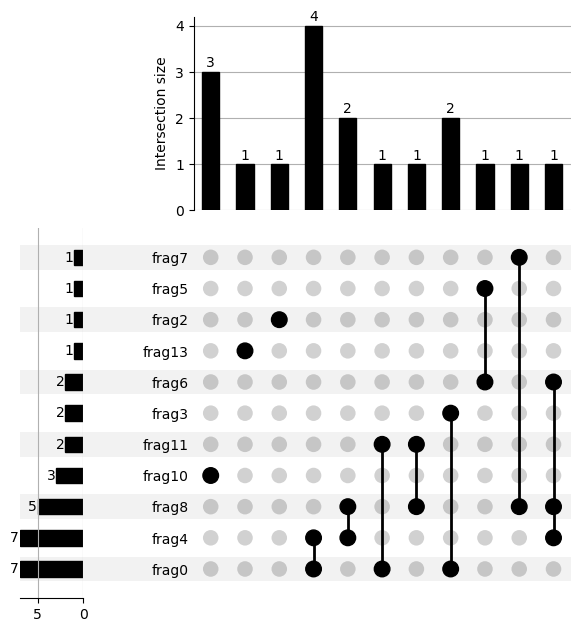

In [35]:
# one-hot
all_fragments_fraggle = set(
    fragment for row in extracted_groups_fraggle for fragment in row
)
one_hot_df_fraggle = pd.DataFrame(
    0, index=range(len(extracted_groups_fraggle)), columns=sorted(all_fragments_fraggle)
)
for i, row in enumerate(extracted_groups_fraggle):
    one_hot_df_fraggle.loc[i, row] = 1

# convert One-Hot encoded data to 'MultiIndex Series'
# and count the number of occurrences of each group
upset_data_fraggle = one_hot_df_fraggle.value_counts()

# create an UpSet plot
upset_fraggle = UpSet(upset_data_fraggle, show_counts="%d")
upset_fraggle.plot()

plt.show()
